# Bioscrape Lineages

# Example 1: How the Simulation Algorithm Works

## The Model

### Transcription Translation CRN
$G \to G + T$

$T \to T + X$

### Cell Growth:
Stochastic Linear Growth

### Cell Division:
Cells deterministically after growing 1 unit. $G$ is duplicated, all other species and volume are partitioned binomially.

### Cell Death:
Cells die at a rate which increases with the amount of $X$: $H(X) = k \frac{X^n}{K^n + X^n}$

In [15]:
from bioscrape.lineage import LineageModel, LineageVolumeSplitter #For building our Model
from bioscrape.lineage import py_SimulateCellLineage, py_SimulateSingleCell
import numpy as np
import pylab as plt

#Python Code to create the model
ktx = .6
ktl = 2.5
kd = .04
rxns = [
    (["G"], ["G","T"], "massaction", {"k":ktx}),
    (["T"], ["T","X"], "massaction", {"k":ktl}),
    (["T"], [], "massaction", {"k":kd}),
]

x0 = {"G":1}
M = LineageModel(reactions = rxns, initial_condition_dict = x0)

vsplit_options = {
    "default":"binomial",
    "G":"duplicate",
}
vsplit = LineageVolumeSplitter(M, options = vsplit_options)

delta = 1
M.create_division_rule("deltaV", {"threshold":delta}, vsplit)
g = .1
kgrow = 1.2
#M.create_volume_event("linear volume", {"growth_rate":g}, "hillnegative", {"k":kgrow, "s1":"S", "n":2, "K":Kgrow})
M.create_volume_event("linear volume", {"growth_rate":g}, "massaction", {"k":kgrow, "species":""})
kdeath = .08
Kdeath = 25
M.create_death_event("death", {}, "hillpositive", {"k":kdeath, "s1":"X", "n":2, "K":Kdeath})
M.py_initialize()

# Single Cell Simulation is SSA Simulation with Volume Dependence

Text(0.5, 1.0, 'A Single Cell')

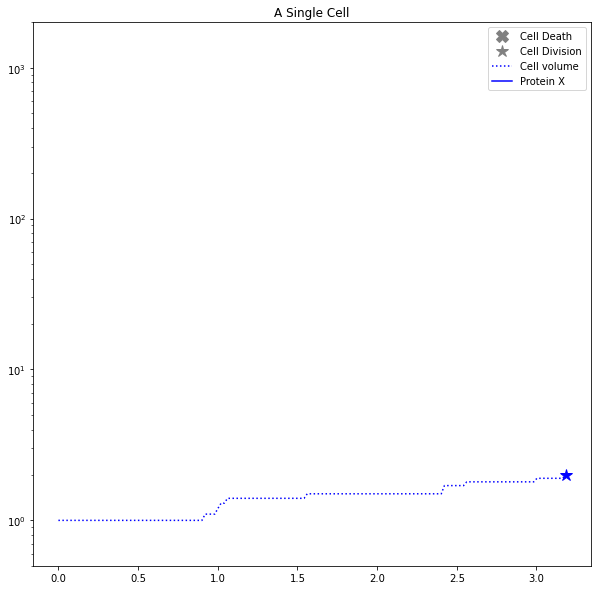

In [16]:
tmax = 20
timepoints = np.linspace(0, tmax, 1000)
ymin = .5
ymax = 2000
ms = 12

#Toggling safe = True will run the simulation in safemode, giving helpful warning messages at the expense of speed.
R = py_SimulateSingleCell(timepoints, Model = M, safe = True)

#plotting
plt.figure(figsize = (10, 10))
plt.plot(0, 0, "X", ms = ms, color = "grey", label = "Cell Death")
plt.plot(0, 0, "*", ms = ms, color = "grey", label = "Cell Division")
plt.plot(R["time"], R["volume"], ":", label = "Cell volume", color = (0, 0, 1))
plt.plot(R["time"], R["X"], label = "Protein X", color = (0, 0, 1))

plt.plot(R["time"][len(R["time"])-1], R["X"][len(R["X"])-1], "*", ms = ms, color = (0, 0, 1))
plt.plot(R["time"][len(R["time"])-1], R["volume"][len(R["volume"])-1], "*", ms = ms, color = (0, 0, 1))

plt.yscale('log')
plt.ylim(ymin, ymax)
plt.legend()
plt.title("A Single Cell")

# Non-interacting Lineage Simulation are many SSA Trajectories Connected by Division Events

Text(0.5, 1.0, 'Non-interactinc Cells')

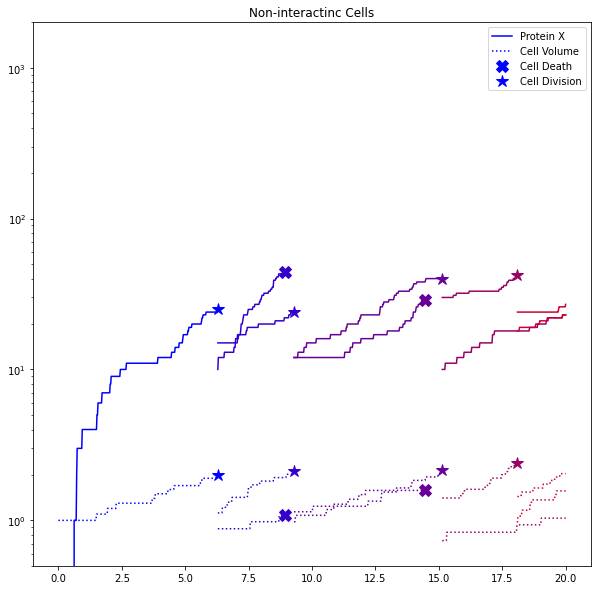

In [17]:
#Simulate a Non-interacting Lineage
lineage = py_SimulateCellLineage(timepoints, Model = M, safe = True)
sch_tree = lineage.get_schnitzes_by_generation()
color_list = [(i/len(sch_tree), 0, 1.-i/len(sch_tree)) for i in range(len(sch_tree))]

#Plotting
plt.figure(figsize = (10, 10))
for generation in range(len(sch_tree)):
    L = sch_tree[generation]
    for sch_ind in range(len(L)):
        sch = L[sch_ind]
    
        df = sch.py_get_dataframe(Model = M)
        
        
        if sch_ind == 0 and generation == 0:
            plt.plot(df["time"], df["X"], color = color_list[generation], label = "Protein X")
            plt.plot(df["time"], df["volume"], ":", color = color_list[generation], label = "Cell Volume")
        else:
            plt.plot(df["time"], df["X"], color = color_list[generation])
            plt.plot(df["time"], df["volume"], ":", color = color_list[generation])
        
        dead = sch.py_get_daughters()[0] is None and df["time"][len(df["time"])-1] < timepoints[-1]
        divided = sch.py_get_daughters()[0] is not None and df["time"][len(df["time"])-1] < timepoints[-1]
        
        if dead:
            plt.plot(df["time"][len(df["time"])-1], df["volume"][len(df["volume"])-1], "X", ms = ms, color = color_list[generation])
            plt.plot(df["time"][len(df["time"])-1], df["X"][len(df["X"])-1], "X", ms = ms, color = color_list[generation])
        if divided:
            plt.plot(df["time"][len(df["time"])-1], df["volume"][len(df["volume"])-1], "*", ms = ms, color = color_list[generation])
            plt.plot(df["time"][len(df["time"])-1], df["X"][len(df["X"])-1], "*", ms = ms, color = color_list[generation])

plt.plot(0, 0, "X", ms = ms, color = color_list[0], label = "Cell Death")
plt.plot(0, 0, "*", ms = ms, color = color_list[0], label = "Cell Division")
plt.yscale('log')
plt.ylim(ymin, ymax)
plt.legend()
plt.title("Non-interactinc Cells")


# Interacting Cells are many SSA trajectories simulated independently and synchronized by remixing global species every $\Delta T$ time

('simulating interacting lineage from ', 2.002002002002002, ' to ', 4.0)
('simulating interacting lineage from ', 4.004004004004004, ' to ', 6.0)
('simulating interacting lineage from ', 6.006006006006006, ' to ', 8.0)
('simulating interacting lineage from ', 8.008008008008009, ' to ', 10.0)
('simulating interacting lineage from ', 10.01001001001001, ' to ', 12.0)
('simulating interacting lineage from ', 12.012012012012011, ' to ', 14.0)
('simulating interacting lineage from ', 14.014014014014014, ' to ', 16.0)
('simulating interacting lineage from ', 16.016016016016017, ' to ', 18.0)
('simulating interacting lineage from ', 18.01801801801802, ' to ', 20.02002002002002)


Text(0.5, 1.0, 'Cells Exchanging X with Each Other and the Enviornment')

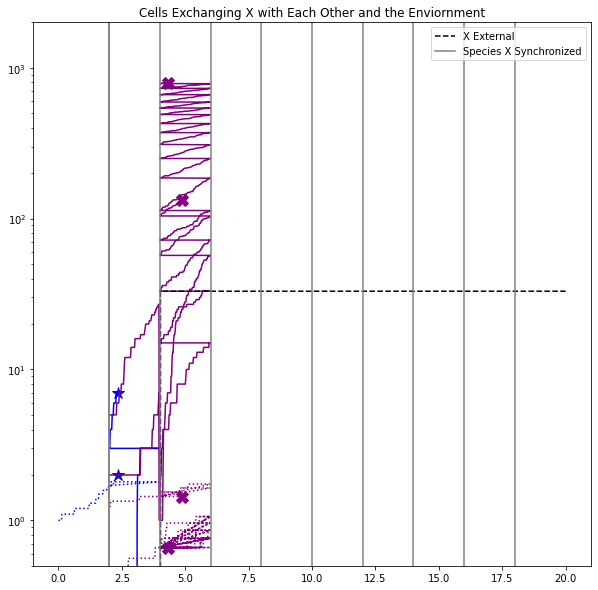

In [18]:
from bioscrape.lineage import py_SimulateInteractingCellLineage
from bioscrape.types import Model

global_sync_period = 2
global_volume = 150
average_dist_threshold = 1
initial_cell_counts = [1]
kdeg = .1
#rxns = [(["X"], [""], "massaction", {"k":kdeg})]
rxns = []
global_crn = Model(species = ["X"], reactions = rxns)

lineage_list, global_results, simulator = py_SimulateInteractingCellLineage(timepoints, global_sync_period, 
                                                                            global_volume = global_volume, 
                                                                            model_list = [M],
                                                                            initial_cell_states = initial_cell_counts,
                                                                            global_species = ["X"],
                                                                            global_volume_model = global_crn,
                                                                            average_dist_threshold = average_dist_threshold,
                                                                            safe = False)

lineage_interacting = lineage_list[0]
sch_tree = lineage_interacting.get_schnitzes_by_generation()
color_list = [(i/len(sch_tree), 0, 1.-i/len(sch_tree)) for i in range(len(sch_tree))]

plt.figure(figsize = (10, 10))
for generation in range(len(sch_tree)):
    L = sch_tree[generation]
    for sch_ind in range(len(L)):
        sch = L[sch_ind]
    
        df = sch.py_get_dataframe(Model = M)
        plt.plot(df["time"], df["volume"], ":", color = color_list[generation])
        
        plt.plot(df["time"], df["X"], color = color_list[generation])
        
        dead = sch.py_get_daughters()[0] is None and df["time"][len(df["time"])-1] < timepoints[-1]
        divided = sch.py_get_daughters()[0] is not None and df["time"][len(df["time"])-1] < timepoints[-1]
        
        if dead:
            plt.plot(df["time"][len(df["time"])-1], df["volume"][len(df["volume"])-1], "X", ms = ms, color = color_list[generation])
            plt.plot(df["time"][len(df["time"])-1], df["X"][len(df["X"])-1], "X", ms = ms, color = color_list[generation])
        if divided:
            plt.plot(df["time"][len(df["time"])-1], df["volume"][len(df["volume"])-1], "*", ms = ms, color = color_list[generation])
            plt.plot(df["time"][len(df["time"])-1], df["X"][len(df["X"])-1], "*", ms = ms, color = color_list[generation])

df_global = global_results.py_get_dataframe(Model = global_crn)
plt.plot(df_global["time"], df_global["X"], "--", label = "X External", color = "black")

for i in range(global_sync_period, tmax, global_sync_period):
    if i == global_sync_period:
        plt.plot([i, i], [ymin, ymax], color = "grey", label = "Species X Synchronized")
    plt.plot([i, i], [ymin, ymax], color = "grey")

plt.yscale('log')
plt.ylim(ymin, ymax)
plt.legend()
plt.title("Cells Exchanging X with Each Other and the Enviornment")

# Example 2: The Bistable Toggle and Rules
## In this example, we will load the Bistable Toggle SBML Model made from BioCRNpyler and Simulate cell Growth and Division Using Rules

## _A cell will grow increasing volume and then divide in two, decreasing volume. Species can be partitioned using a VolumeSplitter. Available partitioning methods are:_
* "binomial"
* "perfect" (proportional to volume)
* "duplicate"
* "custom" (untested functionality for custom partitioning)

### Cells will grow at a constant rate using a "linear" volume rule. 

Other volume rules include: 
* __"multiplicative"__ (for exponentially growing volume)
* __"assignment"__ where the volume is set to any function (key "equation")
* __"ode"__ where $\frac{dV}{dt} = F(state, time)$ is integrated with a Eulers method

### Cells will divide deterministically whenever they have grown by an amount $\Delta$ using a "deltaV" division rule
* Each division rule may have its own, unique, volume splitter

Other division rules include:
* "__time__" where a cell will divide ever $T$ time (key "threshold"). 
* "__volume__" where a cell will divide at some volume threshold (key "threshold").
* "__general__" where a cell divides if a general algebraic expression (key "equation") is greater than 0.

### Cells can also die deterministically using death rules, but we have not used these in the model.
Possible death rules include:
* "__species__" where the cell will die if a certain species (key "species") is ">", "<", or "=" (key "comp") to a threshold (key "threshold").
* "__param__" which is like a species death rule, but for a certain parameter (key "param").
* "__general__" which is like a general division rule.

In [19]:
"""
from bioscrape.lineage import LineageModel, LineageVolumeSplitter #For building our Model
from bioscrape.lineage import py_SimulateCellLineage
import numpy as np
import pylab as plt
import time as pytime
from time import process_time 

#Load Toggle CRN

vsplit_options = {
    "default":"binomial",
    "volume":"binomial",
    "dna_lacI_tetR":"duplicate",
    "dna_tetR_lacI":"duplicate"
}
copy_number = 1
x0 = {"dna_lacI_tetR": copy_number, "dna_tetR_lacI":copy_number}
Mtoggle = LineageModel(sbml_filename = "ToggleCRN.sbml", initial_condition_dict = x0)

print("Species in Mtoggle", list(Mtoggle.get_species()))

g = .015
vsplit = LineageVolumeSplitter(Mtoggle, options = vsplit_options)
#Model Division and Volume with Deterministic Rules
Delta = 1
Mtoggle.create_division_rule("deltaV", {"threshold":Delta}, vsplit)
Mtoggle.create_volume_rule("linear", {"growth_rate":g})"""

'\nfrom bioscrape.lineage import LineageModel, LineageVolumeSplitter #For building our Model\nfrom bioscrape.lineage import py_SimulateCellLineage\nimport numpy as np\nimport pylab as plt\nimport time as pytime\nfrom time import process_time \n\n#Load Toggle CRN\n\nvsplit_options = {\n    "default":"binomial",\n    "volume":"binomial",\n    "dna_lacI_tetR":"duplicate",\n    "dna_tetR_lacI":"duplicate"\n}\ncopy_number = 1\nx0 = {"dna_lacI_tetR": copy_number, "dna_tetR_lacI":copy_number}\nMtoggle = LineageModel(sbml_filename = "ToggleCRN.sbml", initial_condition_dict = x0)\n\nprint("Species in Mtoggle", list(Mtoggle.get_species()))\n\ng = .015\nvsplit = LineageVolumeSplitter(Mtoggle, options = vsplit_options)\n#Model Division and Volume with Deterministic Rules\nDelta = 1\nMtoggle.create_division_rule("deltaV", {"threshold":Delta}, vsplit)\nMtoggle.create_volume_rule("linear", {"growth_rate":g})'

In [20]:
from time import process_time 

"""
#Do the simulation!
timepoints = np.linspace(0, 800, 500)
print("Simulating")
lineage = py_SimulateCellLineage(timepoints = timepoints, Model = Mtoggle)
print("Simulation Complete")

#Lineage objects effectively trees. They contain a are lists of Schnitzes, each with a parent and 2 daughters (which could be none)

#For analysis and plotting purposes, it can be effective to use the function get_schnitzes_by_generation
#this returns a list of lists where the ith entry is a list of all Schnitzes of generation i
sch_tree = lineage.get_schnitzes_by_generation()
print("Total Cells Simulated = ", sum([len(L) for L in sch_tree]),"\nCells of each generation:", [len(L) for L in sch_tree], )"""

'\n#Do the simulation!\ntimepoints = np.linspace(0, 800, 500)\nprint("Simulating")\nlineage = py_SimulateCellLineage(timepoints = timepoints, Model = Mtoggle)\nprint("Simulation Complete")\n\n#Lineage objects effectively trees. They contain a are lists of Schnitzes, each with a parent and 2 daughters (which could be none)\n\n#For analysis and plotting purposes, it can be effective to use the function get_schnitzes_by_generation\n#this returns a list of lists where the ith entry is a list of all Schnitzes of generation i\nsch_tree = lineage.get_schnitzes_by_generation()\nprint("Total Cells Simulated = ", sum([len(L) for L in sch_tree]),"\nCells of each generation:", [len(L) for L in sch_tree], )'

In [21]:
"""
# A little plotting
color_list = [(i/len(sch_tree), 0, 1.-i/len(sch_tree)) for i in range(len(sch_tree))]

print("Plotting")
plt.figure(figsize = (10, 10))
#Plot Generation Counts
plt.subplot(311)
plt.plot(range(len(sch_tree)), [len(L) for L in sch_tree], "o")
plt.ylabel("Number of Cells Per Generation")

#Plot Volume Traces
plt.subplot(312)
for generation in range(len(sch_tree)):
    L = sch_tree[generation]
    for sch in L:
        df = sch.py_get_dataframe(Model = Mtoggle)
        plt.plot(df["time"], df["volume"], color = color_list[generation])
plt.ylabel("Cell Volume Traces")

#Plot lacI
plt.subplot(313)
for generation in range(len(sch_tree)):
    L = sch_tree[generation]
    for sch in L:
        df = sch.py_get_dataframe(Model = Mtoggle)
        plt.plot(df["time"], df["protein_lacI"] - df["protein_tetR"], color = color_list[generation])

plt.plot(timepoints, np.zeros(len(timepoints)), ms = "5", color = "black", label = "TetR = LacI")
plt.legend()
plt.ylabel("LacI - TetR")
"""

'\n# A little plotting\ncolor_list = [(i/len(sch_tree), 0, 1.-i/len(sch_tree)) for i in range(len(sch_tree))]\n\nprint("Plotting")\nplt.figure(figsize = (10, 10))\n#Plot Generation Counts\nplt.subplot(311)\nplt.plot(range(len(sch_tree)), [len(L) for L in sch_tree], "o")\nplt.ylabel("Number of Cells Per Generation")\n\n#Plot Volume Traces\nplt.subplot(312)\nfor generation in range(len(sch_tree)):\n    L = sch_tree[generation]\n    for sch in L:\n        df = sch.py_get_dataframe(Model = Mtoggle)\n        plt.plot(df["time"], df["volume"], color = color_list[generation])\nplt.ylabel("Cell Volume Traces")\n\n#Plot lacI\nplt.subplot(313)\nfor generation in range(len(sch_tree)):\n    L = sch_tree[generation]\n    for sch in L:\n        df = sch.py_get_dataframe(Model = Mtoggle)\n        plt.plot(df["time"], df["protein_lacI"] - df["protein_tetR"], color = color_list[generation])\n\nplt.plot(timepoints, np.zeros(len(timepoints)), ms = "5", color = "black", label = "TetR = LacI")\nplt.legend(

### _Events are like reactions - they fire based upon Propensity functions - but cause Growth, Division, or Death instead of changes of Species counts._
* Events can use any of the propensity types available to reactions



### Cells will grow stochastically using a "linear" with a constant "massaction" propensity (Note this means growth rate will scale linearly with cell Volume)
Other volume events include: 
* __"multiplicative"__ (for exponentially growing volume)
* __"general"__ where the volume is set to any function (key "equation")

### Cells will divide stochastically with a constant "massaction" propensity (Note this means division rate will scale linearly with cell Volume)
* Each division event may have its own, unique, volume splitter


### Cells will die stochastically with a "hillpositive" propensity of cl, lacI, and tetR
* Death destroys the cells


In [22]:
#Use the Same Parameters for both cell types
ke = .05
g = .05

kgrow = 100
Kgrow = 10

kdeath = 1.0
Kdeath = 100

#cell type 1 consumes F (Food) to produce W (Waste) and E (internal machinery aka enzymes)
species = ["F","W", "E"]
rxn1 = [["F","E"], ["E","E","W"], "massaction", {"k":ke}]
Mcell1 = LineageModel(species = species, reactions = [rxn1], initial_condition_dict = {"E":5, "F":1000, "W":0})

vsplit = LineageVolumeSplitter(Mcell1)
Mcell1.create_division_rule("deltaV", {"threshold":1.0}, vsplit)
#E (enzymes) allow the cell to divide
Mcell1.create_volume_event("linear volume", {"growth_rate":g}, "hillpositive", {"k":kgrow, "s1":"E", "n":2, "K":Kgrow})
#Too much waste and the cell dies
Mcell1.create_death_event("death", {}, "hillpositive", {"k":kdeath, "s1":"W", "n":4, "K":Kdeath})

### Tracking a Single Cell Lineage Trace Can be More Efficient and Insightful Than the Entire Ensemble
#### How it Works:
* Every division, one of the daughter cells is randomly discarded!

Simulating
Simulation Complete in 0.03125 s


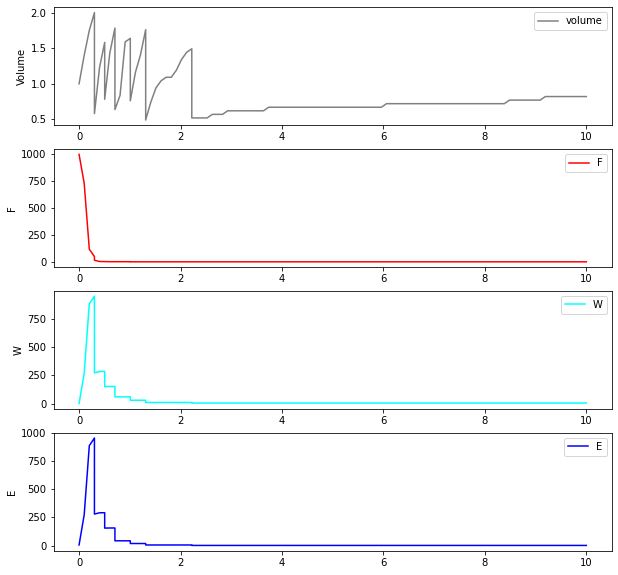

In [23]:
from bioscrape.lineage import py_SingleCellLineage
timepoints = np.linspace(0, 10, 100)
print("Simulating")
ts = process_time()
result_df = py_SingleCellLineage(timepoints = timepoints, Model = Mcell1)
te = process_time()
print("Simulation Complete in", te-ts, "s")

plt.figure(figsize = (10, 10))
plt.subplot(411)
plt.ylabel("Volume")
plt.plot(result_df["time"], result_df["volume"], label = "volume", color = "gray")
plt.legend()
plt.subplot(412)
plt.ylabel("F")
plt.plot(result_df["time"], result_df["F"], label = "F", color = "red")
plt.legend()
plt.subplot(413)
plt.ylabel("W")
plt.plot(result_df["time"], result_df["W"], label = "W", color = "cyan")
plt.legend()
plt.subplot(414)
plt.ylabel("E")
plt.plot(result_df["time"], result_df["E"], label = "E", color = "blue")
plt.legend()

## Example 3: 2 Cell Types Interacting in their Environment

### Cell Type One Consumes Food (F) from the Environment and Produces Waste (W). It's growth rate is based on the amount of F. It dies if exposed to too much W.

### Cell Type 2 Consumes Wast (W) from the Environment. It's growth rate is based on the amount of W.

In [24]:
#A global mode with no reactions is just a container
global_x0 = {"W":0, "F":100}

#Use the Same Parameters for both cell types
ke = .05
g = .025

kgrow = 100
Kgrow = 5

kdeath = 1.0
Kdeath = 100

#cell type 1 consumes F (Food) to produce W (Waste) and E (internal machinery aka enzymes)
species = ["F","W", "E"]
rxn1 = [["F","E"], ["E","E","W"], "massaction", {"k":ke}]
Mcell1 = LineageModel(species = species, reactions = [rxn1], initial_condition_dict = {"E":5})

vsplit = LineageVolumeSplitter(Mcell1)
Mcell1.create_division_rule("deltaV", {"threshold":1.0}, vsplit)
#E (enzymes) allow the cell to divide
Mcell1.create_volume_event("linear volume", {"growth_rate":g}, "hillpositive", {"k":kgrow, "s1":"E", "n":2, "K":Kgrow})
#Too much waste and the cell dies
Mcell1.create_death_event("death", {}, "hillpositive", {"k":kdeath, "s1":"W", "n":4, "K":Kdeath})
#too few enzymes and cell 1 two might die
Mcell1.create_death_event("death", {}, "hillnegative", {"k":.05*kdeath, "s1":"E", "n":4, "K":2})

#Add a food source
kf = .1
rxng = [[], ["F"], "massaction", {"k":kf}]
x0g = {"F":0, "W":0}
Mglobal = Model(species = ["F"], reactions = [rxng], initial_condition_dict = x0g)


#Cell type 2 consumes W to produce E
species = ["W", "E"]
rxn2 = [["W","E"], ["E","E"], "massaction", {"k":ke}]
Mcell2 = LineageModel(species = species, reactions = [rxn1], initial_condition_dict = {"E":5})


vsplit = LineageVolumeSplitter(Mcell2)
Mcell2.create_division_rule("deltaV", {"threshold":1.0}, vsplit)
Mcell2.create_volume_event("linear volume", {"growth_rate":g}, "hillpositive", {"k":kgrow, "s1":"E", "n":2, "K":Kgrow})
#too few enzymes and cell 2 two might die
Mcell2.create_death_event("death", {}, "hillnegative", {"k":.05*kdeath, "s1":"E", "n":4, "K":2})

In [25]:
maxtime = 80
dt = 0.01
global_sync_period = 1.0
global_volume = 1000 #Is the volume that all the cells are growing. If its 0, there is no external volume.
average_dist_threshold = 2.

timepoints = np.arange(0, maxtime+dt, dt)

global_species = ["F", "W"]
model_list = [Mcell1, Mcell2]
initial_cell_counts = [5, 5]

print("Simulating")
ts = process_time()
lineage_list, global_results, simulator = py_SimulateInteractingCellLineage(timepoints, global_sync_period, global_volume = global_volume,
                                                 model_list = model_list, global_volume_model = Mglobal,
                                                 initial_cell_states = initial_cell_counts, 
                                                 global_species = global_species, 
                                                 average_dist_threshold = average_dist_threshold)
df_global = global_results.py_get_dataframe(Model = Mglobal)

for lineage in lineage_list:
    sch_tree = lineage.get_schnitzes_by_generation()
    print("Total Cells Simulated = ", sum([len(L) for L in sch_tree]),"\nCells of each generation:", [len(L) for L in sch_tree], )

Simulating
('simulating interacting lineage from ', 1.0, ' to ', 2.0)
('simulating interacting lineage from ', 2.0, ' to ', 3.0)
('simulating interacting lineage from ', 3.0, ' to ', 4.0)
('simulating interacting lineage from ', 4.0, ' to ', 5.0)
('simulating interacting lineage from ', 5.0, ' to ', 6.0)
('simulating interacting lineage from ', 6.0, ' to ', 7.0)
('simulating interacting lineage from ', 7.0, ' to ', 8.0)
('simulating interacting lineage from ', 8.0, ' to ', 9.0)
('simulating interacting lineage from ', 9.0, ' to ', 10.0)
('simulating interacting lineage from ', 10.0, ' to ', 11.0)
('simulating interacting lineage from ', 11.0, ' to ', 12.0)
('simulating interacting lineage from ', 12.0, ' to ', 13.0)
('simulating interacting lineage from ', 13.0, ' to ', 14.0)
('simulating interacting lineage from ', 14.0, ' to ', 15.0)
('simulating interacting lineage from ', 15.0, ' to ', 16.0)
('simulating interacting lineage from ', 16.0, ' to ', 17.0)
('simulating interacting linea

Plotting


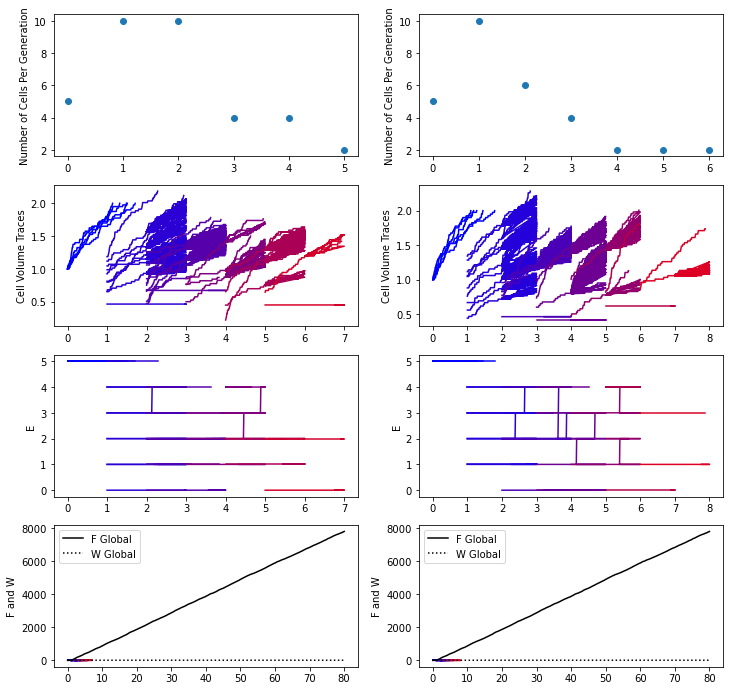

In [26]:
# A little plotting
import pylab as plt

print("Plotting")
plt.figure(figsize = (12, 12))

ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8 = plt.subplot(421), plt.subplot(422), plt.subplot(423), plt.subplot(424), plt.subplot(425), plt.subplot(426), plt.subplot(427), plt.subplot(428)
axes = [ax1, ax3, ax5, ax7, ax2, ax4, ax6, ax8]

for lind in range(len(lineage_list)):
    lineage = lineage_list[lind]
    M = model_list[lind]
    sch_tree = lineage.get_schnitzes_by_generation()
    color_list = [(i/len(sch_tree), 0, 1.-i/len(sch_tree)) for i in range(len(sch_tree))]


    #Plot Generation Counts
    plt.sca(axes[4*lind])
    plt.plot(range(len(sch_tree)), [len(L) for L in sch_tree], "o")
    plt.ylabel("Number of Cells Per Generation")
    

    #Plot Volume Traces
    plt.sca(axes[4*lind+1])
    for generation in range(len(sch_tree)):
        L = sch_tree[generation]
        for sch in L:
            df = sch.py_get_dataframe(Model = M)
            plt.plot(df["time"], df["volume"], color = color_list[generation])
    plt.ylabel("Cell Volume Traces")

    #Plot E
    plt.sca(axes[4*lind+2])
    for generation in range(len(sch_tree)):
        L = sch_tree[generation]
        for sch in L:
            df = sch.py_get_dataframe(Model = M)
            plt.plot(df["time"], df["E"], color = color_list[generation])
    plt.ylabel("E")
    
    #Plot F, W
    plt.sca(axes[4*lind+3])
    for generation in range(len(sch_tree)):
        L = sch_tree[generation]
        for sch in L:
            df = sch.py_get_dataframe(Model = M)
            plt.plot(df["time"], df["F"], color = color_list[generation])
            plt.plot(df["time"], df["W"], ":", color = color_list[generation])
            
    plt.plot(df_global["time"], df_global["F"], color = "black", label = "F Global")
    plt.plot(df_global["time"], df_global["W"], ":", color = "black", label = "W Global")
    plt.legend()
    plt.ylabel("F and W")



# Propogate Cells is simpler than a faster lineage simulation and returns snapshots at periodic timepoints

In [27]:
from bioscrape.lineage import py_PropagateInteractingCells
print("Simulating")
ts = process_time()
#Instead of simulating a whole cell Lineage, use propogate cells to get snapshots over time
#lineage_list, global_results, simulator = py_SimulateInteractingCellLineage(timepoints, global_sync_period, global_volume = global_volume,
#                                                 model_list = model_list, global_volume_model = Mglobal,
#                                                 initial_cell_states = initial_cell_counts, 
#                                                 global_species = global_species, 
#                                                 average_dist_threshold = average_dist_threshold)

Nsamples = 11
sample_list, sample_times, global_results, simulator = py_PropagateInteractingCells(timepoints, global_sync_period, 
                                                 sample_times = Nsamples, global_volume = global_volume,
                                                 model_list = model_list, global_volume_model = Mglobal,
                                                 initial_cell_states = initial_cell_counts, 
                                                 global_species = global_species, 
                                                 average_dist_threshold = average_dist_threshold)
te = process_time()
print("Simulation Complete in", te-ts, "s")

print("N cell 1:", [len(L[0]) for L in sample_list])
print("N cell 2:", [len(L[1]) for L in sample_list])

Simulating
Simulation Complete in 0.078125 s
N cell 1: [5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
N cell 2: [5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


[[7809.    8.]
 [ 680.    0.]
 [1522.    0.]
 [2321.    0.]
 [3106.    0.]
 [3871.    0.]
 [4672.    0.]
 [5488.    0.]
 [6262.    0.]
 [7066.    0.]
 [7894.    0.]]
sample_times [ 0.  8. 16. 24. 32. 40. 48. 56. 64. 72. 80.]


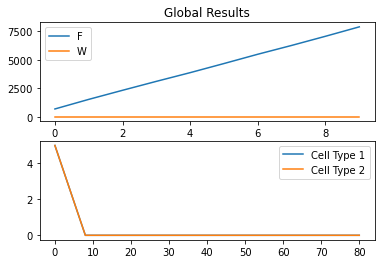

In [28]:
print(global_results.py_get_result())
print("sample_times", sample_times)
plt.figure()
plt.subplot(211)
plt.title("Global Results")
plt.plot(global_results.py_get_result()[1:, 0], label = "F")
plt.plot(global_results.py_get_result()[1:, 1], label = "W")
plt.legend()

plt.subplot(212)
plt.plot(sample_times, [len(L[0]) for L in sample_list], label = "Cell Type 1")
plt.plot(sample_times, [len(L[1]) for L in sample_list], label = "Cell Type 2")
plt.legend()